In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Let's write a simple model which could capture the following empirical observations (for an average subject first, we'll deal with individual differences later)
 - Drivers use two perceptual quantities in making a decision: distance (d) and time-to-arrival (TTA)
 - Probability of turning increases with both d and TTA
 - Response time increases with TTA
 - Response time decreases with d

In [48]:
def dx(A, c, dt):
    return A*dt + c*np.random.randn()*np.sqrt(dt)

def run_trial(tta, tta_crit, boundary, noise_intensity, n):
    # our decisions are on the timescale of 1-2 seconds, we use 10ms as integration step for now
    dt = 0.01

    # for each trial, we will store the whole dynamics of the simulation, include timestamps, and for 
    # each timestamp (t): current drift rate (tta), current evidence value (x)
    timestamps = [0]
    drift_rate_values = [tta-tta_crit]
    evidence_values = [0]

    while (abs(evidence_values[-1]) < boundary):
        t = timestamps[-1] + dt

        # drift rate at time t
        drift_rate = drift_rate_values[0]-t
        drift_rate_values.append(drift_rate)

        # accumulated evidence at time t
        evidence_values.append(evidence_values[-1] + dx(drift_rate, noise_intensity, dt))
        timestamps.append(t)

    is_turn_decision = (evidence_values[-1] > boundary)
        
    return pd.DataFrame(data={'n': n,
                              't': np.array(timestamps),
                              'x': np.array(evidence_values),
                              'd': np.array(drift_rate_values),
                              'is_turn_decision': is_turn_decision})

def run_sim(tta, tta_crit, boundary, noise_intensity, n_sim):
    trials = [run_trial(tta, tta_crit, boundary, noise_intensity, n) for n in range(n_sim)]
    
    return pd.concat(trials).set_index(['n'])

In [108]:
def plot_ddm_traces(sim_data):
    turn_rate = sim_data.groupby('n').is_turn_decision.last().mean()
    mean_turn_rt = sim_data[sim_data.is_turn_decision].groupby('n').t.last().mean()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
    axes = (ax1, ax2, ax3)
    
    t = np.linspace(0, 3, 10)
#     d = np.linspace(0, sim_data.d.iloc[0], 10)
    ax2.plot(t, sim_data.d.iloc[0]-t, color='grey')
    
    for n, traj in sim_data.groupby('n'):
        is_turn_decision = traj.is_turn_decision.iloc[-1]
        color = 'C1' if is_turn_decision else 'C2'
        alpha = 0.3 if is_turn_decision else 0.1
        ax1.plot(traj.t, traj.x, color=color, alpha=alpha)
        ax2.plot([traj.t.values[-1]], [traj.d.values[-1]], color=color, marker='o', alpha=alpha)
    
    sns.kdeplot(ax=ax3, data=sim_data[sim_data.is_turn_decision].groupby('n').t.last(), color='C1', shade=True, legend=False)

    ax1.set_ylabel('evidence $x$')
    ax2.set_ylabel('$tta-tta_{crit}$')
    ax3.set_ylabel('pdf $P(t=t_{ap})$')    
    
#     for ax in axes:
#         ax.set_xlabel('time $t$')
#         ax.axvline(mean_turn_rt, color='grey', ls='--')    

    ax2.set_title('Turn rate$=%.f\%%$, mean turn RT $=%.2f$s' % (100*turn_rate, mean_turn_rt))
    
    return axes

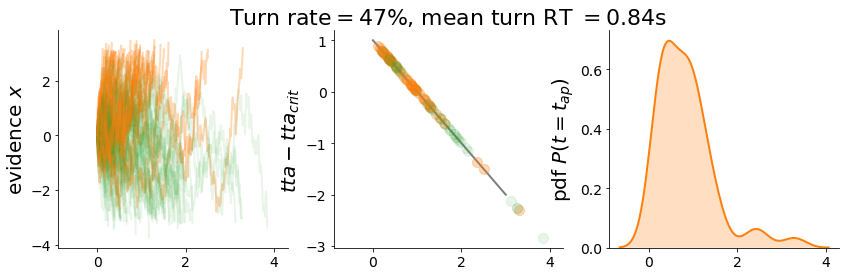

In [118]:
sim_data = run_sim(tta=4, tta_crit=3, boundary=3, noise_intensity=3, n_sim=100)
axes = plot_ddm_traces(sim_data)